# Modeling

In [1]:
import pandas as pd
import numpy as np
from glob import glob
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [2]:
# Step 1: Load all feature CSVs

file_paths = sorted(glob("/Users/sarvesh/Desktop/wesad/data/features/S*_features.csv")) 
subject_ids = [f.split("/")[-1].split("_")[0] for f in file_paths]

In [3]:
# Step 2: Track metrics
accuracies = []
f1s = []
per_subject_reports = {}

In [4]:
# Step 3: LOSO loop
for i, test_subj in enumerate(subject_ids):
    print(f"\n🔄 Testing on {test_subj} (LOSO fold {i+1}/{len(subject_ids)})")

    test_df = pd.read_csv(file_paths[i])
    train_dfs = [pd.read_csv(f) for j, f in enumerate(file_paths) if j != i]
    train_df = pd.concat(train_dfs, ignore_index=True)

    # Optional: binary classification
    train_df = train_df[train_df['label'].isin([1, 2])].replace({'label': {1: 0, 2: 1}})
    test_df = test_df[test_df['label'].isin([1, 2])].replace({'label': {1: 0, 2: 1}})

    X_train, y_train = train_df.drop(columns=['label']), train_df['label']
    X_test, y_test = test_df.drop(columns=['label']), test_df['label']

    # Step 4: Train model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Step 5: Evaluate
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    accuracies.append(acc)
    f1s.append(f1)
    per_subject_reports[test_subj] = classification_report(y_test, y_pred, output_dict=True)

    print(f"✅ Accuracy: {acc:.4f} | F1: {f1:.4f}")




🔄 Testing on S10 (LOSO fold 1/15)
✅ Accuracy: 1.0000 | F1: 1.0000

🔄 Testing on S11 (LOSO fold 2/15)
✅ Accuracy: 0.9206 | F1: 0.8837

🔄 Testing on S13 (LOSO fold 3/15)
✅ Accuracy: 1.0000 | F1: 1.0000

🔄 Testing on S14 (LOSO fold 4/15)
✅ Accuracy: 0.9677 | F1: 0.9524

🔄 Testing on S15 (LOSO fold 5/15)
✅ Accuracy: 0.9677 | F1: 0.9545

🔄 Testing on S16 (LOSO fold 6/15)
✅ Accuracy: 1.0000 | F1: 1.0000

🔄 Testing on S17 (LOSO fold 7/15)
✅ Accuracy: 1.0000 | F1: 1.0000

🔄 Testing on S2 (LOSO fold 8/15)
✅ Accuracy: 0.7797 | F1: 0.7636

🔄 Testing on S3 (LOSO fold 9/15)
✅ Accuracy: 0.8500 | F1: 0.8235

🔄 Testing on S4 (LOSO fold 10/15)
✅ Accuracy: 0.9667 | F1: 0.9500

🔄 Testing on S5 (LOSO fold 11/15)
✅ Accuracy: 1.0000 | F1: 1.0000

🔄 Testing on S6 (LOSO fold 12/15)
✅ Accuracy: 0.9836 | F1: 0.9778

🔄 Testing on S7 (LOSO fold 13/15)
✅ Accuracy: 1.0000 | F1: 1.0000

🔄 Testing on S8 (LOSO fold 14/15)
✅ Accuracy: 0.8226 | F1: 0.7843

🔄 Testing on S9 (LOSO fold 15/15)
✅ Accuracy: 1.0000 | F1: 1.00

In [5]:
# Step 6: Summary
print("\n📊 LOSO Summary:")
print(f"Mean Accuracy: {np.mean(accuracies):.4f}")
print(f"Mean F1 Score: {np.mean(f1s):.4f}")


📊 LOSO Summary:
Mean Accuracy: 0.9506
Mean F1 Score: 0.9393


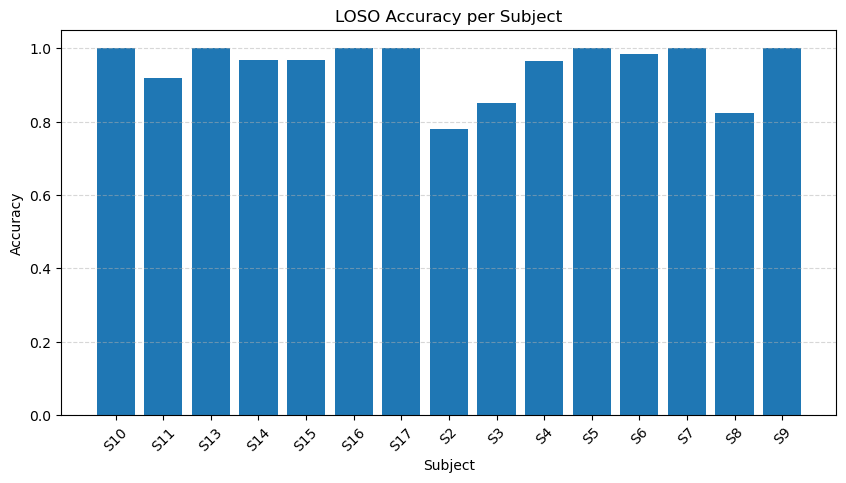

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(subject_ids, accuracies)
plt.title("LOSO Accuracy per Subject")
plt.ylabel("Accuracy")
plt.xlabel("Subject")
plt.xticks(rotation=45)
plt.ylim(0, 1.05)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


In [7]:
importances = model.feature_importances_  # only for tree-based models
pd.Series(importances, index=X_train.columns).sort_values(ascending=False).head(10)


eda_mean               0.325036
eda_peak_count         0.197939
resp_std               0.150090
eda_std                0.074152
eda_slope              0.071363
mean_rr                0.058861
ecg_peak_count         0.037914
resp_zero_crossings    0.037522
rmssd                  0.019035
resp_mean              0.015995
dtype: float64

In [8]:
# Step 3: LOSO loop
for i, test_subj in enumerate(subject_ids):
    print(f"\n🔄 Testing on {test_subj} (LOSO fold {i+1}/{len(subject_ids)})")

    test_df = pd.read_csv(file_paths[i])
    train_dfs = [pd.read_csv(f) for j, f in enumerate(file_paths) if j != i]
    train_df = pd.concat(train_dfs, ignore_index=True)

    # 🟢 No binary filtering; use all available labels
    X_train, y_train = train_df.drop(columns=['label']), train_df['label']
    X_test, y_test = test_df.drop(columns=['label']), test_df['label']

    # Step 4: Train model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Step 5: Evaluate
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')  # 🟢 Weighted F1 for multiclass

    accuracies.append(acc)
    f1s.append(f1)
    per_subject_reports[test_subj] = classification_report(y_test, y_pred, output_dict=True)

    print(f"✅ Accuracy: {acc:.4f} | F1 (weighted): {f1:.4f}")


🔄 Testing on S10 (LOSO fold 1/15)


/Users/sarvesh/anaconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sarvesh/anaconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sarvesh/anaconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

✅ Accuracy: 0.7418 | F1 (weighted): 0.7028

🔄 Testing on S11 (LOSO fold 2/15)


/Users/sarvesh/anaconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sarvesh/anaconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sarvesh/anaconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

✅ Accuracy: 0.6647 | F1 (weighted): 0.6366

🔄 Testing on S13 (LOSO fold 3/15)


/Users/sarvesh/anaconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sarvesh/anaconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sarvesh/anaconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

✅ Accuracy: 0.7213 | F1 (weighted): 0.6749

🔄 Testing on S14 (LOSO fold 4/15)


/Users/sarvesh/anaconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sarvesh/anaconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sarvesh/anaconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

✅ Accuracy: 0.5519 | F1 (weighted): 0.4882

🔄 Testing on S15 (LOSO fold 5/15)


/Users/sarvesh/anaconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sarvesh/anaconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sarvesh/anaconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

✅ Accuracy: 0.6149 | F1 (weighted): 0.5397

🔄 Testing on S16 (LOSO fold 6/15)


/Users/sarvesh/anaconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sarvesh/anaconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sarvesh/anaconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

✅ Accuracy: 0.7043 | F1 (weighted): 0.6612

🔄 Testing on S17 (LOSO fold 7/15)


/Users/sarvesh/anaconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sarvesh/anaconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sarvesh/anaconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

✅ Accuracy: 0.6122 | F1 (weighted): 0.5831

🔄 Testing on S2 (LOSO fold 8/15)


/Users/sarvesh/anaconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sarvesh/anaconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sarvesh/anaconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

✅ Accuracy: 0.4975 | F1 (weighted): 0.4006

🔄 Testing on S3 (LOSO fold 9/15)


/Users/sarvesh/anaconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sarvesh/anaconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sarvesh/anaconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

✅ Accuracy: 0.6698 | F1 (weighted): 0.6047

🔄 Testing on S4 (LOSO fold 10/15)


/Users/sarvesh/anaconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sarvesh/anaconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sarvesh/anaconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

✅ Accuracy: 0.5211 | F1 (weighted): 0.4688

🔄 Testing on S5 (LOSO fold 11/15)


/Users/sarvesh/anaconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sarvesh/anaconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sarvesh/anaconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

✅ Accuracy: 0.6715 | F1 (weighted): 0.6278

🔄 Testing on S6 (LOSO fold 12/15)


/Users/sarvesh/anaconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sarvesh/anaconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sarvesh/anaconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

✅ Accuracy: 0.7393 | F1 (weighted): 0.7003

🔄 Testing on S7 (LOSO fold 13/15)


/Users/sarvesh/anaconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sarvesh/anaconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sarvesh/anaconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

✅ Accuracy: 0.5029 | F1 (weighted): 0.4212

🔄 Testing on S8 (LOSO fold 14/15)


/Users/sarvesh/anaconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sarvesh/anaconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sarvesh/anaconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

✅ Accuracy: 0.4088 | F1 (weighted): 0.3340

🔄 Testing on S9 (LOSO fold 15/15)
✅ Accuracy: 0.6994 | F1 (weighted): 0.6611


/Users/sarvesh/anaconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sarvesh/anaconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sarvesh/anaconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.